# **Heart Disease Prediction with Machine Learning**

## Load the Data

In [1]:
!kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease


  0%|          | 0.00/21.4M [00:00<?, ?B/s]
 14%|█▍        | 3.00M/21.4M [00:00<00:00, 27.2MB/s]
 28%|██▊       | 6.00M/21.4M [00:00<00:00, 16.5MB/s]
 51%|█████▏    | 11.0M/21.4M [00:00<00:00, 27.4MB/s]
 75%|███████▍  | 16.0M/21.4M [00:00<00:00, 33.8MB/s]
 98%|█████████▊| 21.0M/21.4M [00:00<00:00, 37.1MB/s]
100%|██████████| 21.4M/21.4M [00:00<00:00, 32.2MB/s]


In [2]:
!tar -xf personal-key-indicators-of-heart-disease.zip

In [3]:
!mkdir .\kaggle\input

A subdirectory or file .\kaggle\input already exists.


In [4]:
!move .\2020\heart_2020_cleaned.csv .\kaggle\input
!move .\2022\heart_2022_no_nans.csv .\kaggle\input
!move .\2022\heart_2022_with_nans.csv .\kaggle\input

        1 file(s) moved.
        1 file(s) moved.
        1 file(s) moved.


In [5]:
!rmdir .\2020
!rmdir .\2022

## Import Libraries

In [6]:
# Data Preprocessing and Visualization
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import warnings

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("pastel"))

warnings.filterwarnings('ignore', category=FutureWarning)

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, \
                                OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Under Sampling 
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss, \
                                    OneSidedSelection, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, \
                                    TomekLinks, AllKNN, InstanceHardnessThreshold, NeighbourhoodCleaningRule, \
                                    CondensedNearestNeighbour
from sklearn.cluster import MiniBatchKMeans

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Hyperparameter Tuning
from sklearn.model_selection import StratifiedShuffleSplit

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Saving the Model
import pickle

In [7]:
data_dir = os.path.join('kaggle', 'input')
for dir_name, _, file_names in os.walk(data_dir):
    for file_name in file_names:
        print(os.path.join(dir_name, file_name))

kaggle\input\heart_2020_cleaned.csv
kaggle\input\heart_2022_no_nans.csv
kaggle\input\heart_2022_with_nans.csv


In [8]:
df = pd.read_csv(os.path.join(data_dir, 'heart_2022_with_nans.csv'))
print(df.shape)
df.head()

(445132, 40)


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [10]:
nans = df.isna().sum().sort_values(ascending=False)
percent = nans / df.shape[0] * 100
pd.DataFrame({'NaNs Count': nans, 'Percent NaNs': percent})

,NaNs Count,Percent NaNs
TetanusLast10Tdap,82516,18.537423
PneumoVaxEver,77040,17.307226
HIVTesting,66127,14.855593
ChestScan,56046,12.590872
CovidPos,50764,11.404258
HighRiskLastYear,50623,11.372582
BMI,48806,10.964388
FluVaxLast12,47121,10.585849
AlcoholDrinkers,46574,10.462964
WeightInKilograms,42078,9.452926


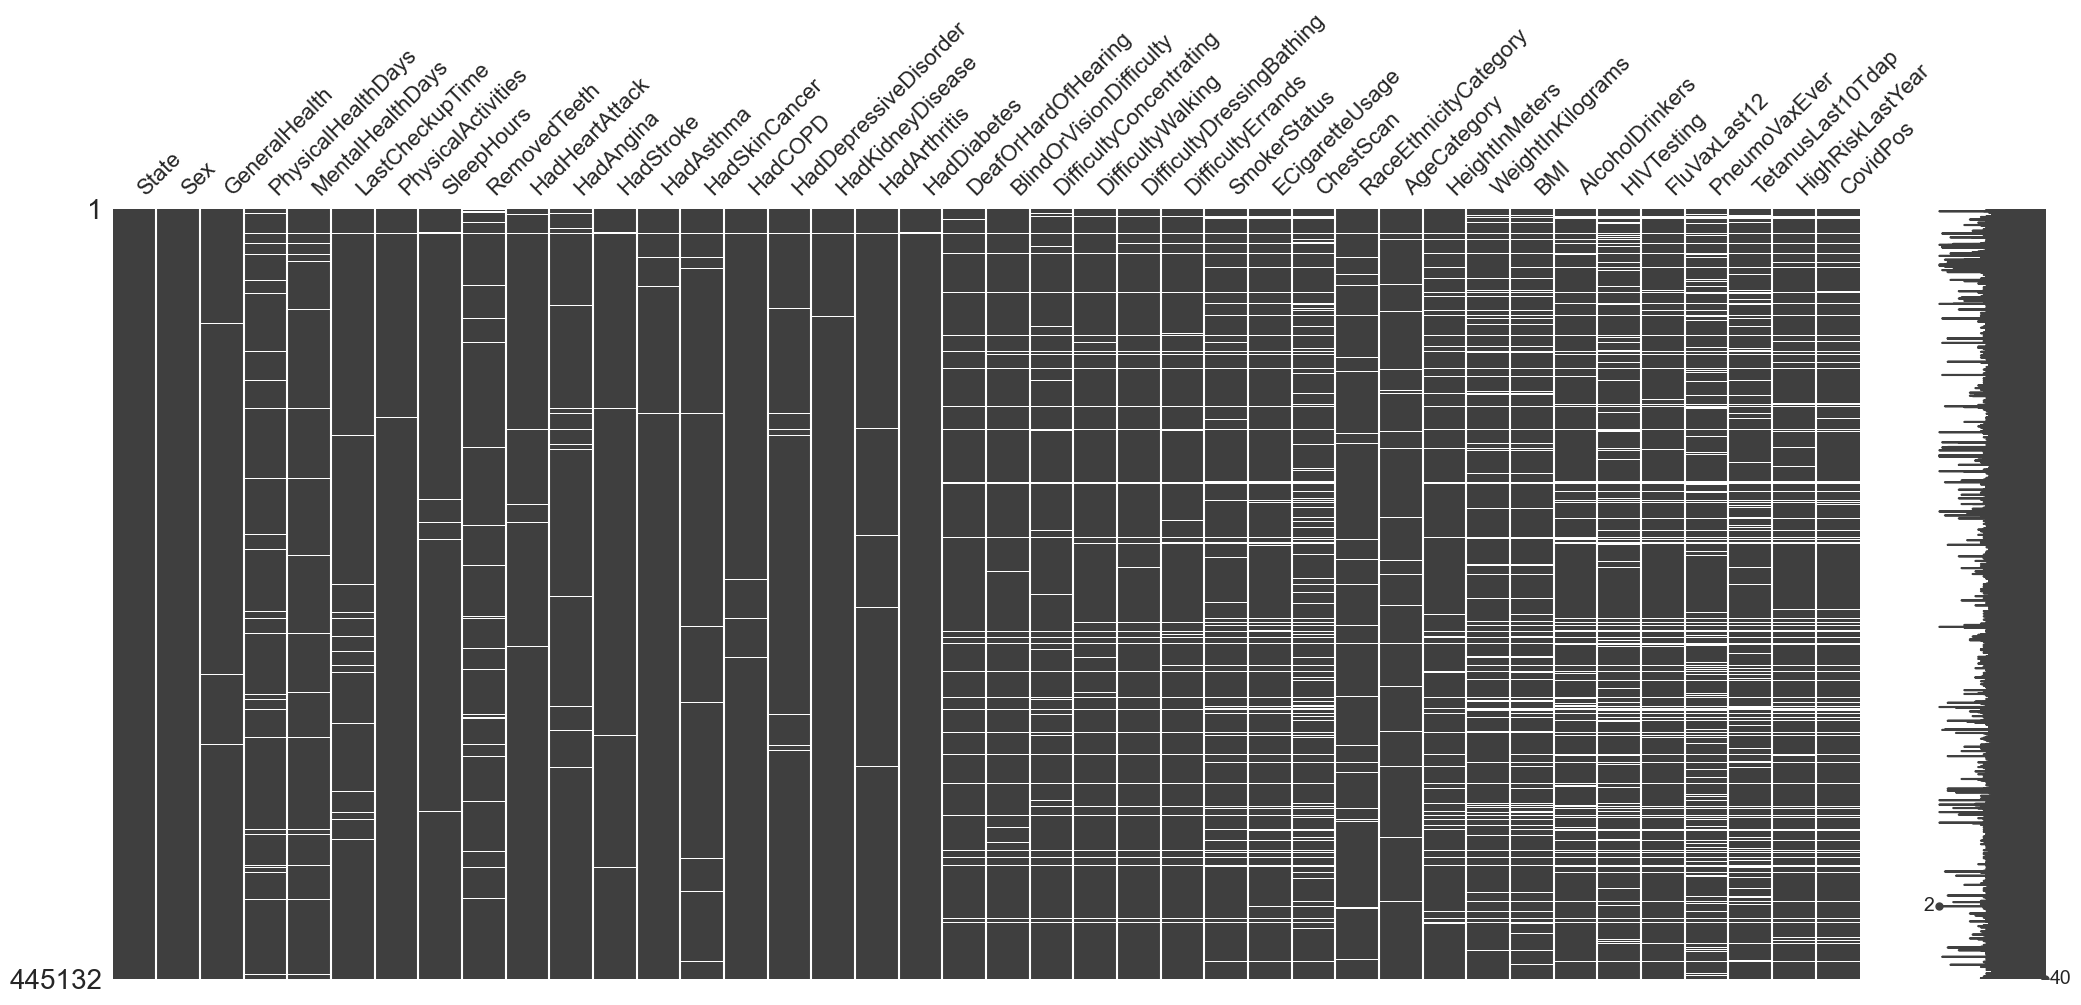

In [11]:
msno.matrix(df)
plt.show()

## Data Cleaning

### Drop Missing Values 
    - alternatives: KNNImputer, impute with mean, impute with 0

In [12]:
df = df.dropna()
df.isna().sum()

State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     

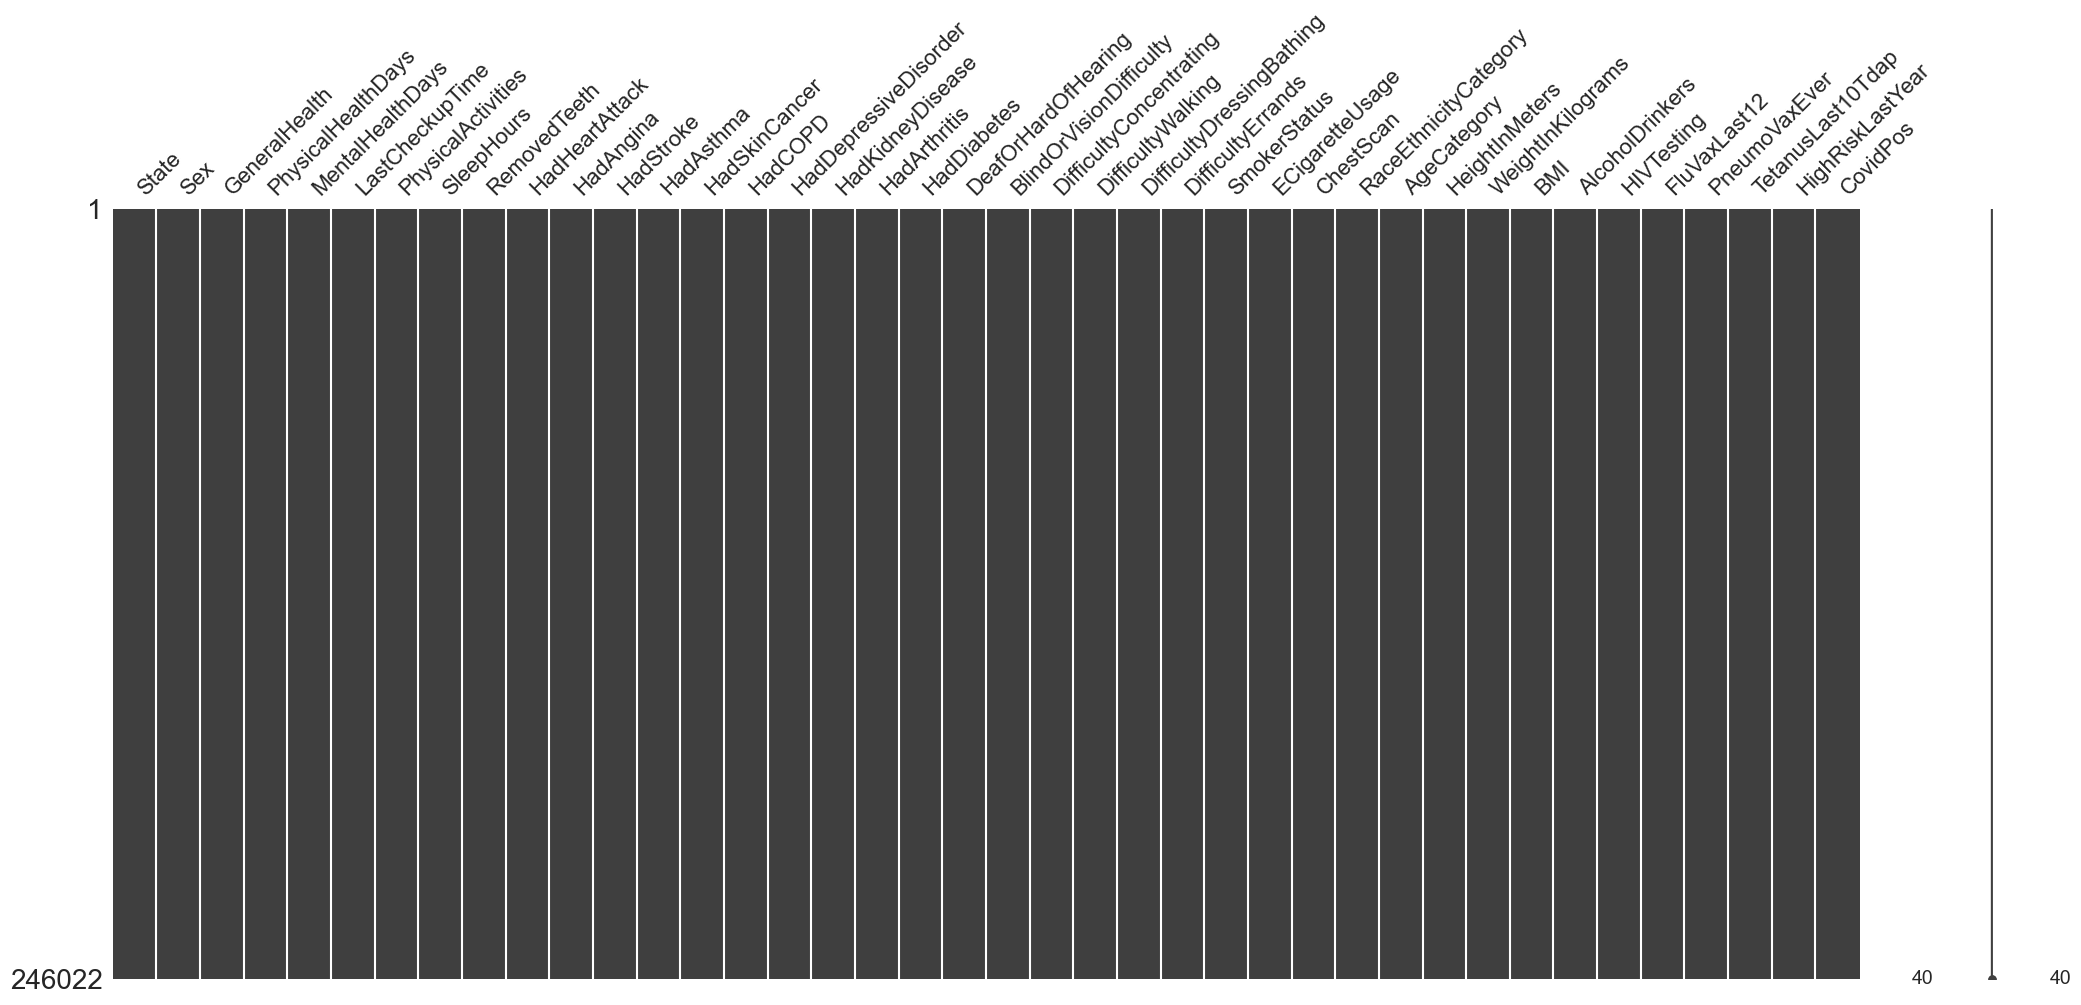

In [13]:
msno.matrix(df)
plt.show()

### Drop Duplicates

In [14]:
df.duplicated().sum()

9

In [15]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Get the Categorical and Numeric Cols

In [16]:
df.drop(['State'], axis=1, inplace=True)
df.drop(['RaceEthnicityCategory'], axis=1, inplace=True)
df.shape

(246013, 38)

In [17]:
category_cols = df.select_dtypes(include='object').columns
numeric_cols = df.select_dtypes(exclude='object').columns
print('Category Columns:', category_cols)
print('Numeric Columns:', numeric_cols)

Category Columns: Index(['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma',
       'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
       'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing',
       'BlindOrVisionDifficulty', 'DifficultyConcentrating',
       'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
       'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AgeCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Numeric Columns: Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')


In [18]:
for colunm in category_cols:
    print(f'{colunm}: {df[colunm].unique()}')
    print('-'*100)

Sex: ['Female' 'Male']
----------------------------------------------------------------------------------------------------
GeneralHealth: ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
----------------------------------------------------------------------------------------------------
LastCheckupTime: ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
----------------------------------------------------------------------------------------------------
PhysicalActivities: ['Yes' 'No']
----------------------------------------------------------------------------------------------------
RemovedTeeth: ['None of them' '6 or more, but not all' '1 to 5' 'All']
----------------------------------------------------------------------------------------------------
HadHeartAttack: ['No' 'Yes']
-----------------------------------------------------------------

In [19]:
for column in numeric_cols:
      print(f'{column}: Min: {df[column].min()}, Max: {df[column].max()}, Mean: {round(df[column].mean(), 2)}, Median: {round(df[column].median(), 2)}, Std: {round(df[column].std(), 2)}')
      print('-'*100)

PhysicalHealthDays: Min: 0.0, Max: 30.0, Mean: 4.12, Median: 0.0, Std: 8.41
----------------------------------------------------------------------------------------------------
MentalHealthDays: Min: 0.0, Max: 30.0, Mean: 4.17, Median: 0.0, Std: 8.1
----------------------------------------------------------------------------------------------------
SleepHours: Min: 1.0, Max: 24.0, Mean: 7.02, Median: 7.0, Std: 1.44
----------------------------------------------------------------------------------------------------
HeightInMeters: Min: 0.91, Max: 2.41, Mean: 1.71, Median: 1.7, Std: 0.11
----------------------------------------------------------------------------------------------------
WeightInKilograms: Min: 28.12, Max: 292.57, Mean: 83.62, Median: 81.65, Std: 21.32
----------------------------------------------------------------------------------------------------
BMI: Min: 12.02, Max: 97.65, Mean: 28.67, Median: 27.46, Std: 6.51
-------------------------------------------------------

## Exploratory Data Analysis

In [20]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['HadHeartAttack'])
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

print(train.shape, test.shape)

(196810, 38) (49203, 38)


### Heart Disease Rate

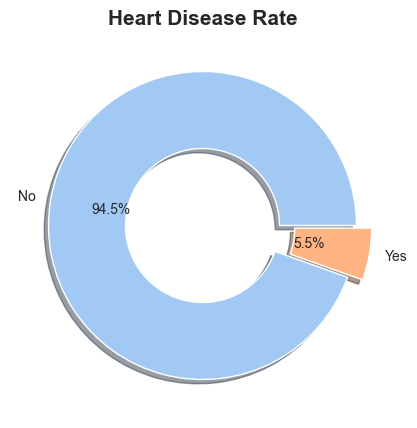

In [21]:
plt.figure(figsize=(5, 5))
heart_disease_rate = train['HadHeartAttack'].value_counts()
plt.pie(heart_disease_rate.values, labels=heart_disease_rate.index, autopct="%.1f%%",
        wedgeprops=dict(width=0.5, edgecolor='w'), shadow=True, explode=[0, 0.1])
plt.title('Heart Disease Rate', fontsize=15, fontweight='bold')
plt.show()

### Heart Disease Among Different Genders

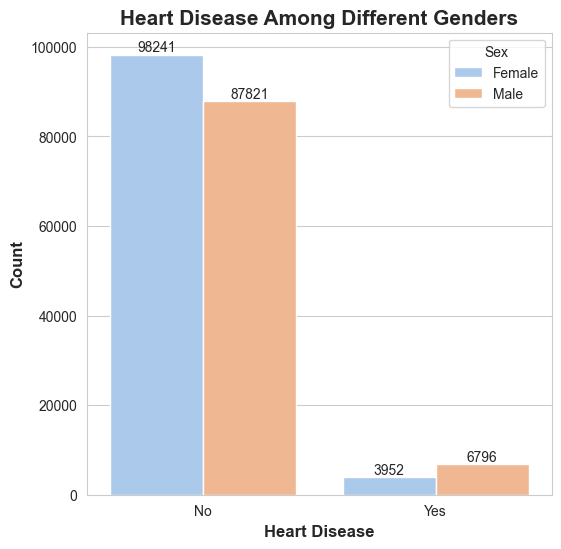

In [22]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data=train, x='HadHeartAttack', hue='Sex')
ax.set_title("Heart Disease Among Different Genders", fontsize=15, fontweight='bold')
ax.set_xlabel("Heart Disease", fontsize=12, fontweight='bold')
ax.set_ylabel("Count", fontsize=12, fontweight='bold')

for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize=10)
    
plt.show()

### Risk Factors

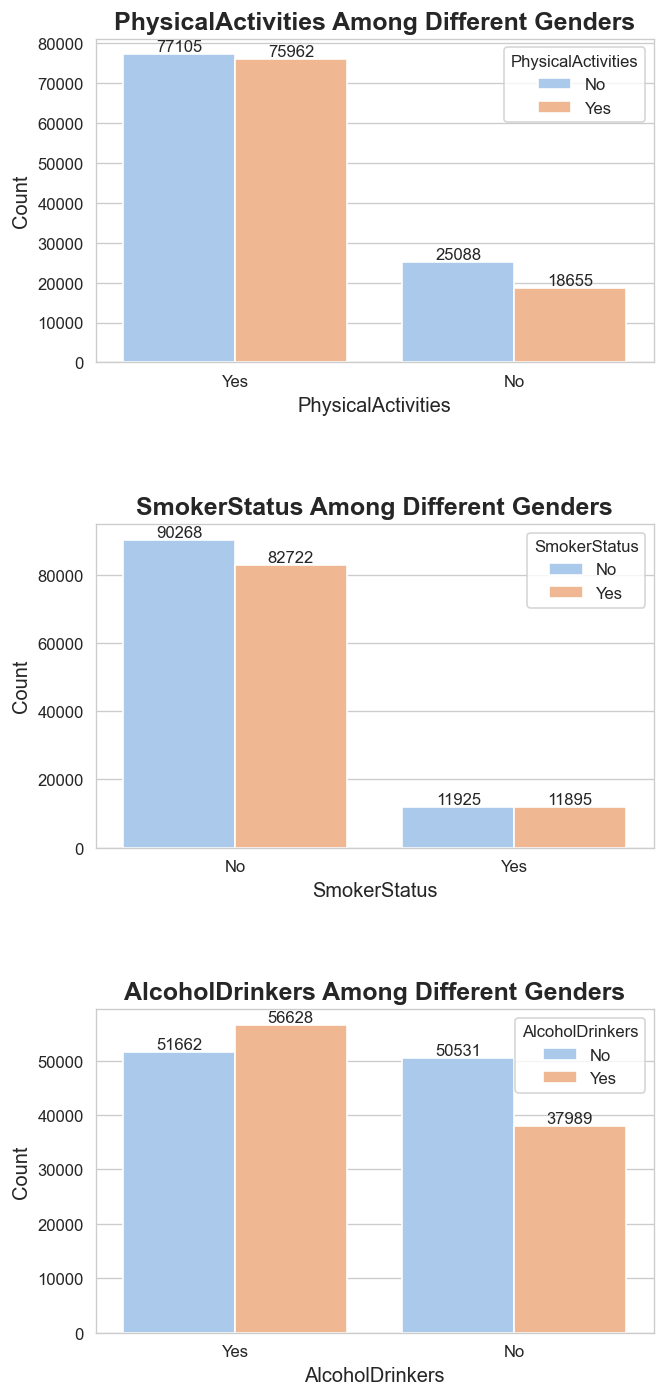

In [23]:
replacements = {
    'Never smoked': 'No',
    'Former smoker': 'No',
    'Current smoker - now smokes some days': 'Yes',
    'Current smoker - now smokes every day': 'Yes'
}

train['SmokerStatus'].replace(replacements, inplace=True)

plt.figure(figsize=(6, 14), dpi = 120)
risk_factors = ['PhysicalActivities', 'SmokerStatus', 'AlcoholDrinkers']
for i, risk_factor in enumerate(risk_factors, 1):
    plt.subplot(3, 1, i)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    x = sns.countplot(data=train, x=risk_factor, hue='Sex')
    plt.title(f"{risk_factor} Among Different Genders", fontsize=15, fontweight='bold')
    plt.xlabel(f"{risk_factor}", fontsize=12)
    plt.ylabel("Count", fontsize=12,)
    plt.legend(title=f'{risk_factor}', labels=['No', 'Yes'], fontsize=10)
    for c in x.containers:
        x.bar_label(c, label_type='edge', fontsize=10)
plt.show()

In [24]:
train['AgeCategory'].value_counts()

AgeCategory
Age 65 to 69       22968
Age 60 to 64       21404
Age 70 to 74       20562
Age 55 to 59       17735
Age 50 to 54       15860
Age 75 to 79       14530
Age 80 or older    14231
Age 40 to 44       13566
Age 45 to 49       13452
Age 35 to 39       12456
Age 30 to 34       10674
Age 18 to 24       10503
Age 25 to 29        8869
Name: count, dtype: int64

In [25]:
train['AgeCategory'] = train['AgeCategory'].str.replace(' to ', '-')
train['AgeCategory'] = train['AgeCategory'].str.replace('Age ', '')
train['AgeCategory'].value_counts()

AgeCategory
65-69          22968
60-64          21404
70-74          20562
55-59          17735
50-54          15860
75-79          14530
80 or older    14231
40-44          13566
45-49          13452
35-39          12456
30-34          10674
18-24          10503
25-29           8869
Name: count, dtype: int64

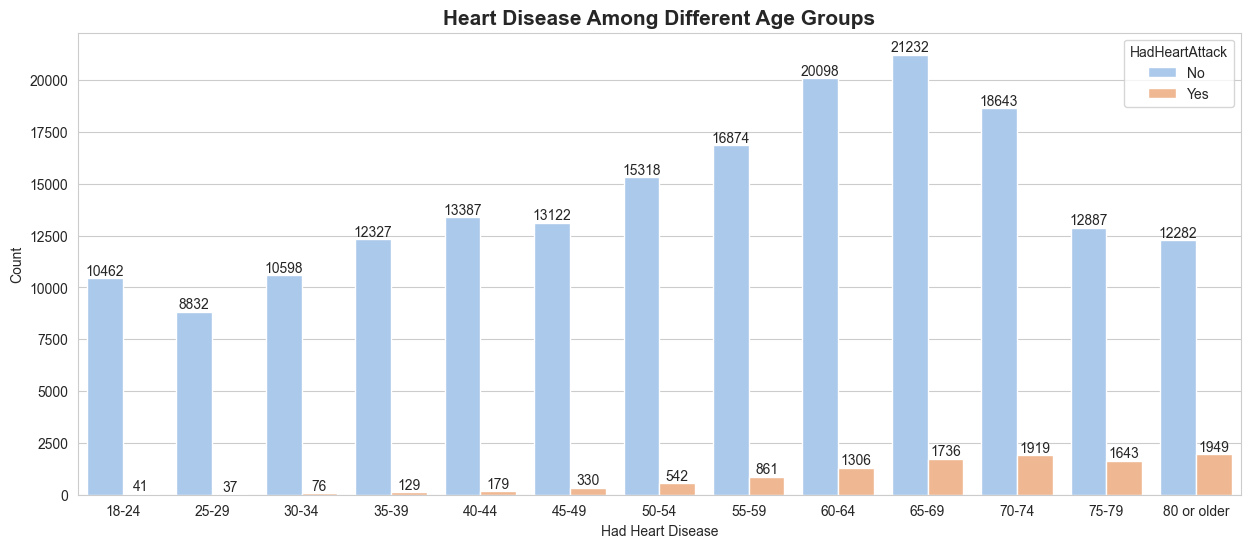

In [26]:
# Set figure size and style
plt.figure(figsize=(15, 6))

# Plot countplot
ax = sns.countplot(data=train, x='AgeCategory', hue='HadHeartAttack',
                   order = train['AgeCategory'].value_counts().sort_index().index.values)

# Customize plot
ax.set_title("Heart Disease Among Different Age Groups", fontsize=15, weight='bold')
ax.set_xlabel("Had Heart Disease")
ax.set_ylabel("Count",)

# Add labels to bars
for c in ax.containers:
    ax.bar_label(c)

# Show plot
plt.show()

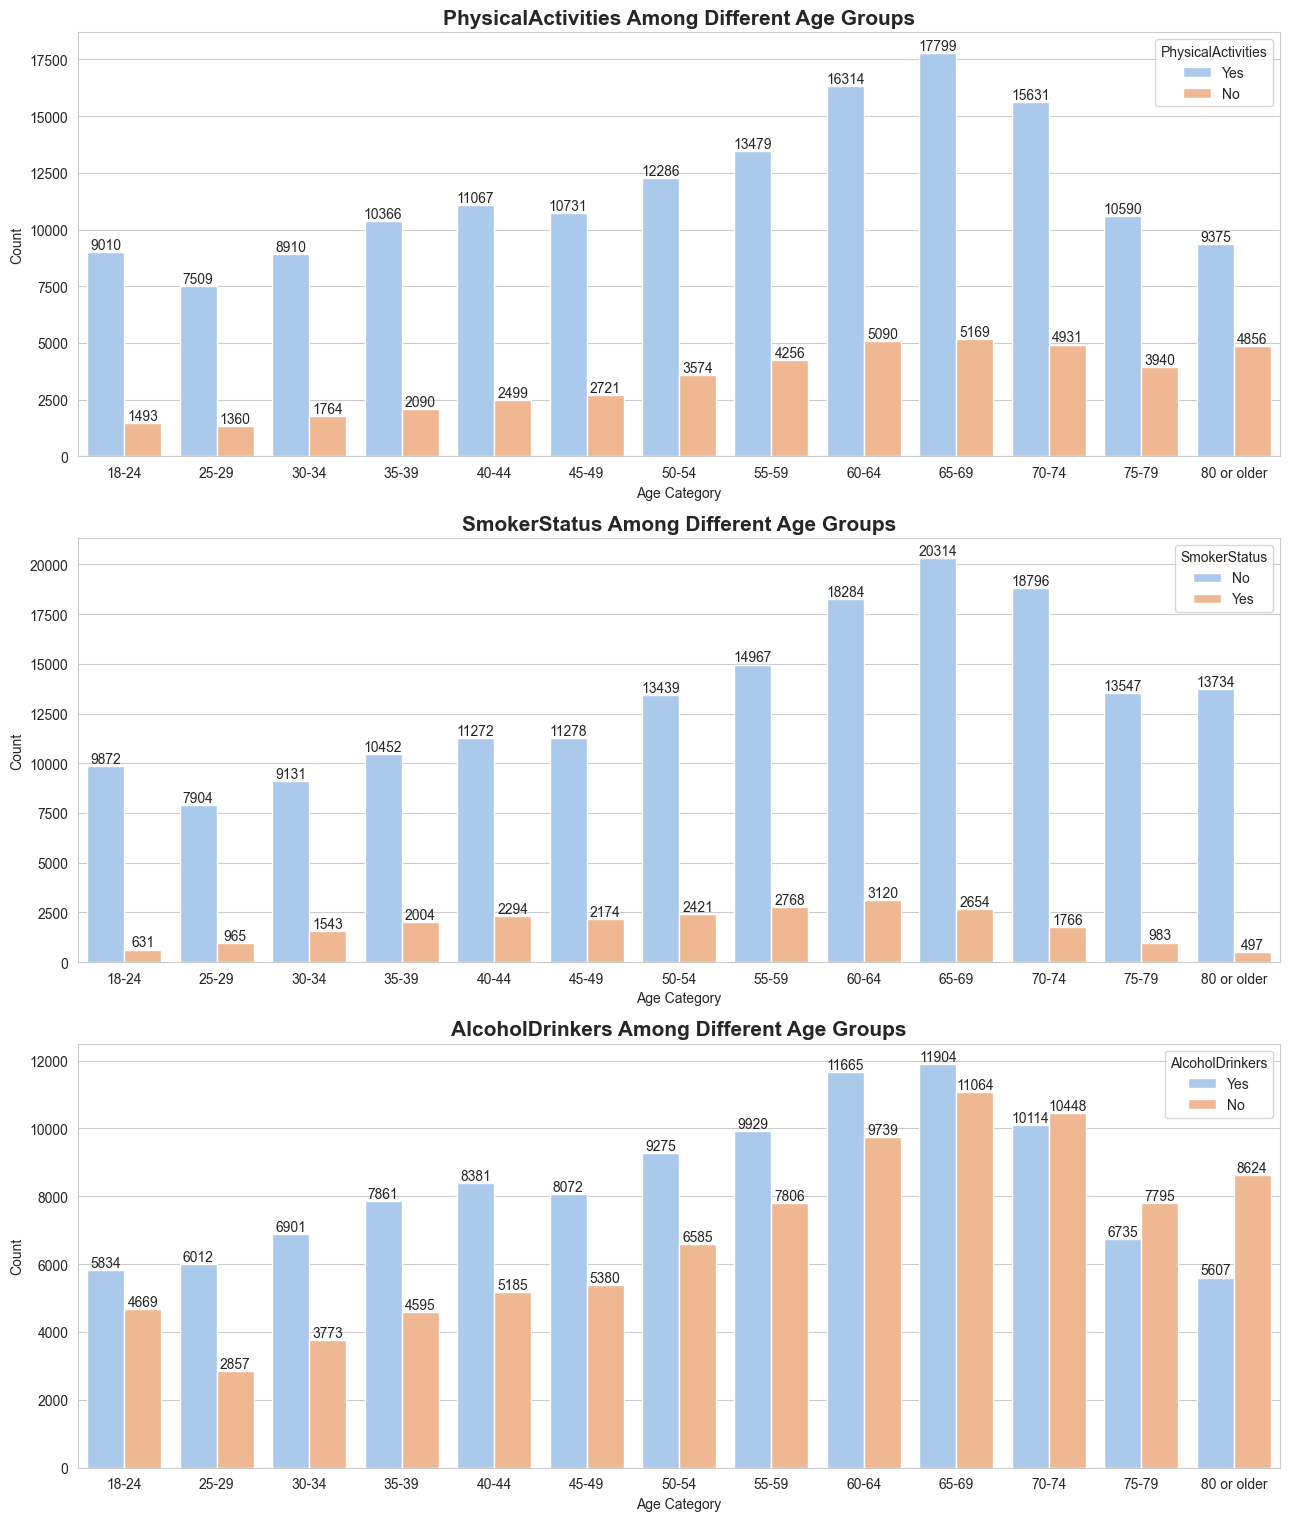

In [27]:
plt.figure(figsize=(13, 25))
risk_factors = ['PhysicalActivities', 'SmokerStatus', 'AlcoholDrinkers']
for i, risk_factor in enumerate(risk_factors, 1):
    plt.subplot(5, 1, i)
    x = sns.countplot(data=train, x='AgeCategory', hue=risk_factor,
                     order = train['AgeCategory'].value_counts().sort_index().index.values)
    plt.title(f"{risk_factor} Among Different Age Groups", fontsize=15, weight='bold')
    plt.xlabel("Age Category")
    plt.ylabel("Count")
    for c in x.containers:
        x.bar_label(c)
plt.tight_layout()

plt.show()

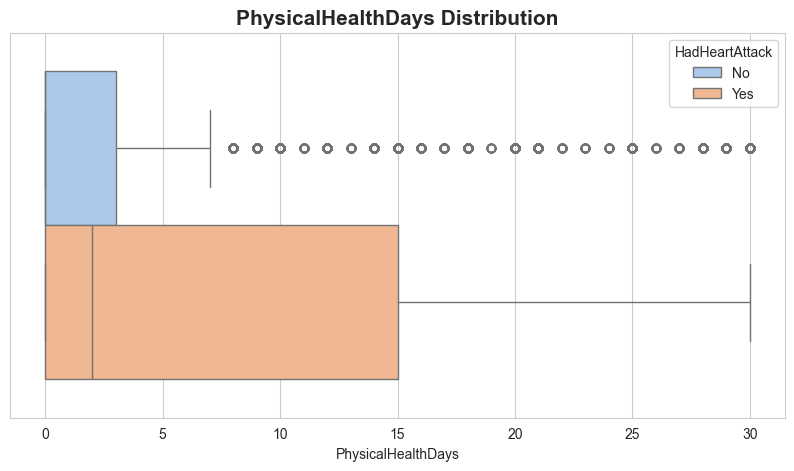

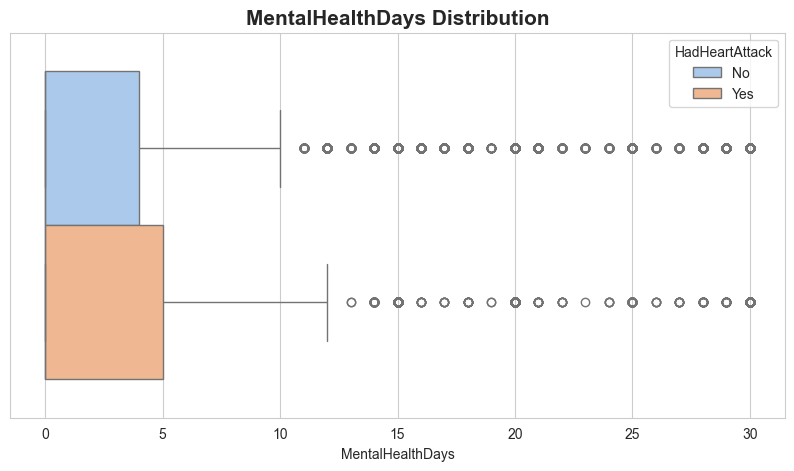

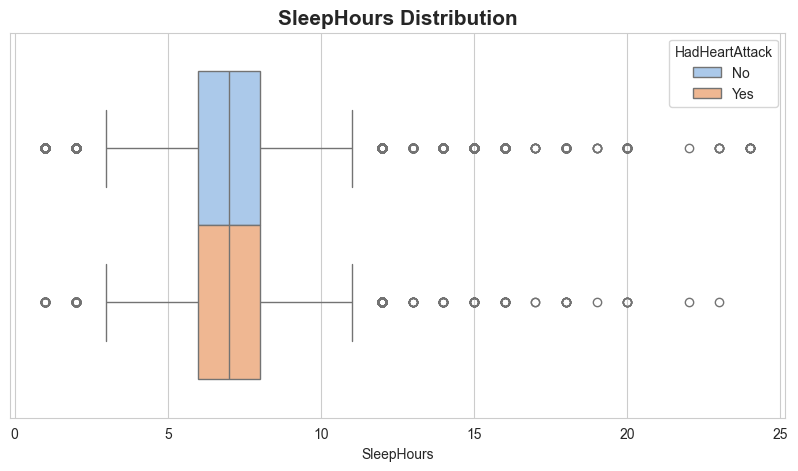

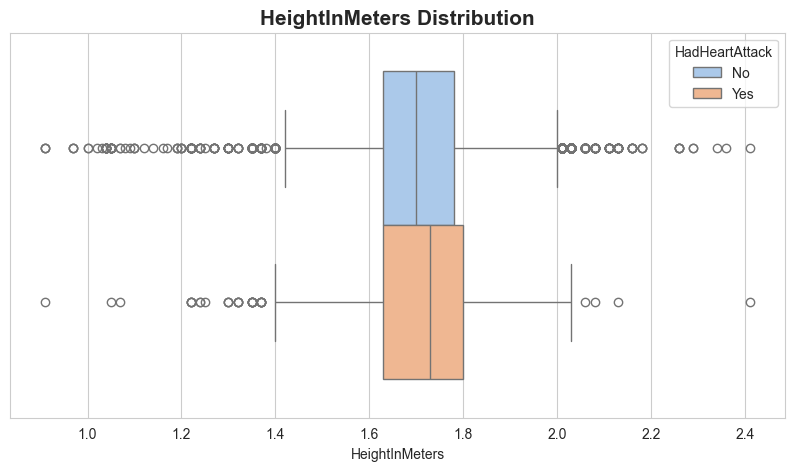

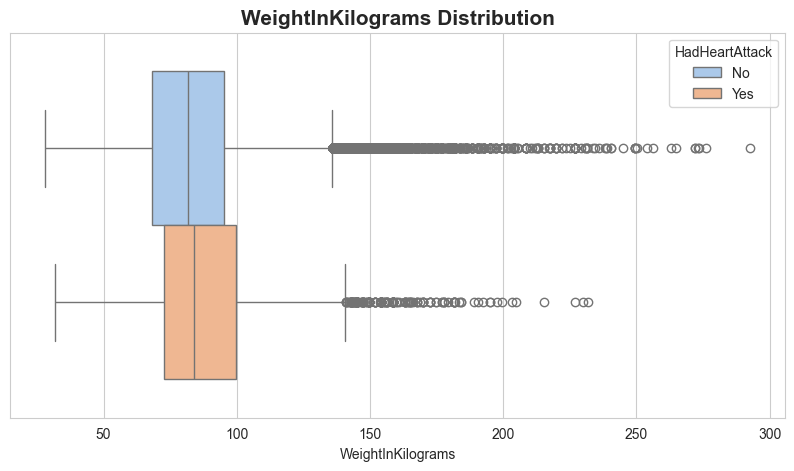

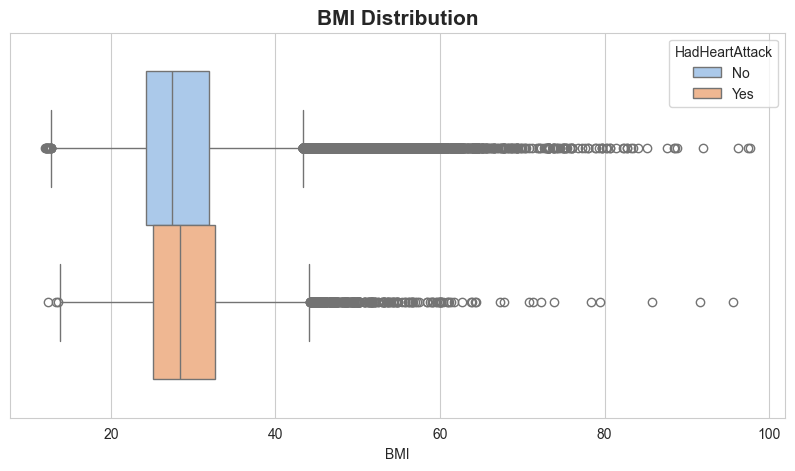

In [28]:
for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train, x=col, hue='HadHeartAttack')
    plt.title(f'{col} Distribution', fontsize=15, fontweight='bold')
    plt.show()

## Preprocessing Pipeline

In [29]:
from sklearn.model_selection import train_test_split
temp, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['HadHeartAttack'])

train, val = train_test_split(temp, test_size=0.125, random_state=42, stratify=temp['HadHeartAttack'])

train = train.reset_index(drop = True)
val = val.reset_index(drop = True)
test = test.reset_index(drop = True)

print(train.shape, val.shape, test.shape)
print(round((100*train.shape[0]/df.shape[0]), 2),
      round((100*val.shape[0]/df.shape[0]), 2),
      round((100*test.shape[0]/df.shape[0]), 2))

(172208, 38) (24602, 38) (49203, 38)
70.0 10.0 20.0


In [30]:
X_train, y_train = train.drop(columns = 'HadHeartAttack'), train['HadHeartAttack']
X_val, y_val = val.drop(columns = 'HadHeartAttack'), val['HadHeartAttack']
X_test, y_test = test.drop(columns = 'HadHeartAttack'), test['HadHeartAttack']

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(172208, 37) (172208,)
(24602, 37) (24602,)
(49203, 37) (49203,)


In [31]:
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(exclude='object').columns
print('Categorical Columns:', categorical_cols)
print('Numeric Columns:', numeric_cols)

Categorical Columns: Index(['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'AgeCategory', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Numeric Columns: Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')


### Encode Categorial Attributes

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        
    def fit(self, X, y=None):
        self.encoding = {
            'Sex': dict(zip(['Female', 'Male'], [0, 1])),
            'GeneralHealth': dict(zip(['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], range(5))),
            'LastCheckupTime': dict(zip(['5 or more years ago', 'Within past 5 years (2 years but less than 5 years ago)', 'Within past 2 years (1 year but less than 2 years ago)', 'Within past year (anytime less than 12 months ago)'], range(4))),
            'PhysicalActivities': dict(zip(['No', 'Yes'], [0, 1])),
            'RemovedTeeth': dict(zip(['All', '6 or more, but not all', '1 to 5', 'None of them'], range(4))),
            # 'HadHeartAttack': dict(zip(['No', 'Yes'], [0, 1])),
            'HadAngina': dict(zip(['No', 'Yes'], [0, 1])),
            'HadStroke': dict(zip(['No', 'Yes'], [0, 1])),
            'HadAsthma': dict(zip(['No', 'Yes'], [0, 1])),
            'HadSkinCancer': dict(zip(['No', 'Yes'], [0, 1])),
            'HadCOPD': dict(zip(['No', 'Yes'], [0, 1])),
            'HadDepressiveDisorder': dict(zip(['No', 'Yes'], [0, 1])),
            'HadKidneyDisease': dict(zip(['No', 'Yes'], [0, 1])),
            'HadArthritis': dict(zip(['No', 'Yes'], [0, 1])),
            'HadDiabetes': dict(zip(['No', 'No, pre-diabetes or borderline diabetes', 'Yes, but only during pregnancy (female)', 'Yes'], range(4))),
            'DeafOrHardOfHearing': dict(zip(['No', 'Yes'], [0, 1])),
            'BlindOrVisionDifficulty': dict(zip(['No', 'Yes'], [0, 1])),
            'DifficultyConcentrating': dict(zip(['No', 'Yes'], [0, 1])),
            'DifficultyWalking': dict(zip(['No', 'Yes'], [0, 1])),
            'DifficultyDressingBathing': dict(zip(['No', 'Yes'], [0, 1])),
            'DifficultyErrands': dict(zip(['No', 'Yes'], [0, 1])),
            'SmokerStatus': dict(zip(['Never smoked', 'Former smoker', 'Current smoker - now smokes some days', 'Current smoker - now smokes every day'], range(4))),
            'ECigaretteUsage': dict(zip(['Never used e-cigarettes in my entire life', 'Not at all (right now)', 'Use them some days', 'Use them every day'], range(4))),
            'ChestScan': dict(zip(['No', 'Yes'], [0, 1])),
            'AgeCategory': dict(zip(['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older'], range(13))),
            'AlcoholDrinkers': dict(zip(['No', 'Yes'], [0, 1])),
            'HIVTesting': dict(zip(['No', 'Yes'], [0, 1])),
            'FluVaxLast12': dict(zip(['No', 'Yes'], [0, 1])),
            'PneumoVaxEver': dict(zip(['No', 'Yes'], [0, 1])),
            'TetanusLast10Tdap': dict(zip(['No, did not receive any tetanus shot in the past 10 years', 'Yes, received tetanus shot, but not Tdap', 'Yes, received tetanus shot but not sure what type', 'Yes, received Tdap'], range(4))),
            'HighRiskLastYear': dict(zip(['No', 'Yes'], [0, 1])),
            'CovidPos': dict(zip(['No', 'Tested positive using home test without a health professional', 'Yes'], range(3))),
        }
        self.feature_names = X.columns
        
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for col in self.encoding.keys():
            X_[col] = X_[col].map(self.encoding[col])
            X_[col] = X_[col].astype('int')
        return X_
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def get_feature_names_out(self, names=None):
        return self.feature_names

encoder = OrdinalEncoder()
encoder.fit_transform(X_train[categorical_cols])

,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,ECigaretteUsage,ChestScan,AgeCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,1,1,3,1,3,0,0,0,0,0,...,0,0,1,0,0,1,0,2,0,0
1,0,2,2,0,3,0,0,0,0,0,...,1,1,3,1,1,1,0,0,0,0
2,1,2,0,1,3,0,0,0,0,0,...,1,0,2,0,0,0,0,0,0,0
3,0,0,3,0,0,0,0,0,0,0,...,0,1,7,0,0,1,1,2,0,0
4,1,4,3,1,3,0,0,0,0,0,...,0,0,7,1,0,0,0,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172203,0,2,3,1,2,0,0,0,0,0,...,0,1,10,1,0,0,1,2,0,0
172204,1,3,3,1,2,0,0,0,0,0,...,1,1,9,1,1,1,1,3,0,2
172205,1,4,3,1,3,0,0,0,0,0,...,0,0,8,1,1,0,0,1,0,0
172206,0,3,3,1,3,0,0,0,1,0,...,0,0,10,1,0,1,1,3,0,0


### Power Transformer
    - Box-Cox requires input data to be strictly positive
    - Yeo-Johnson can handle features with zero or negative values

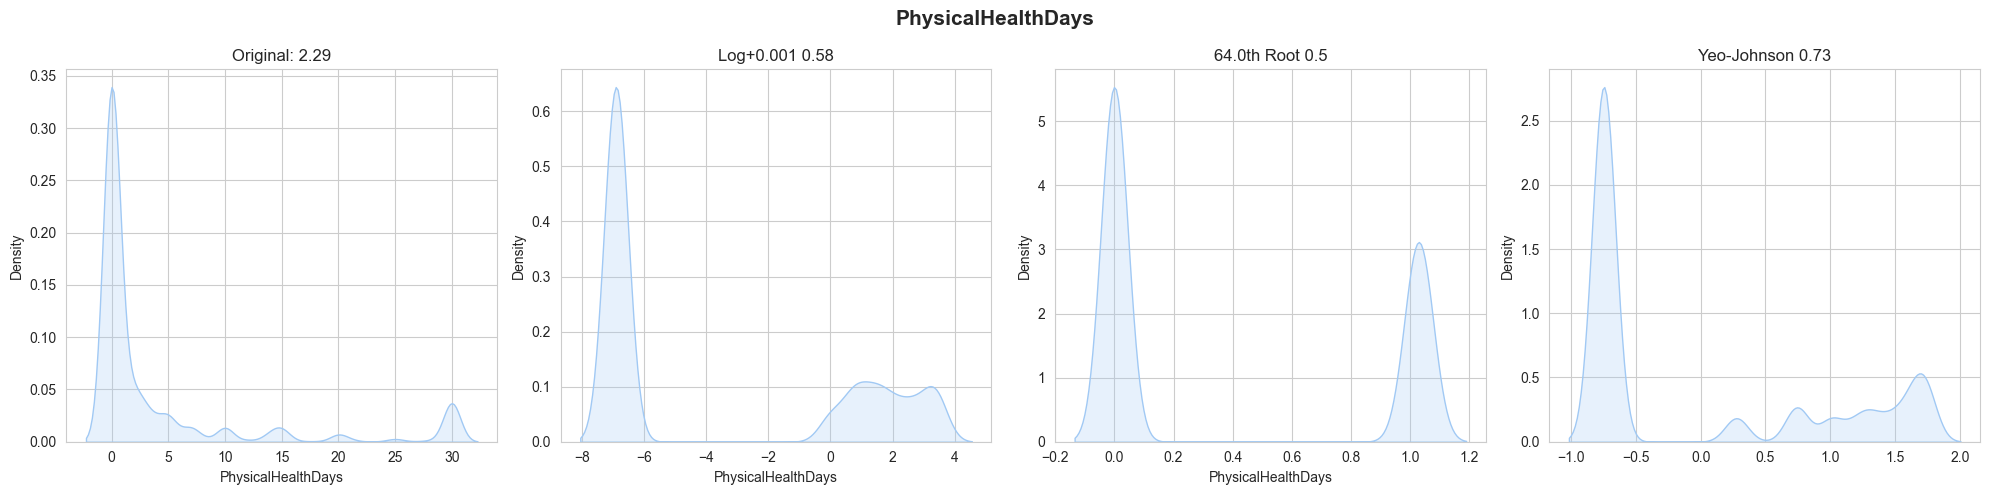

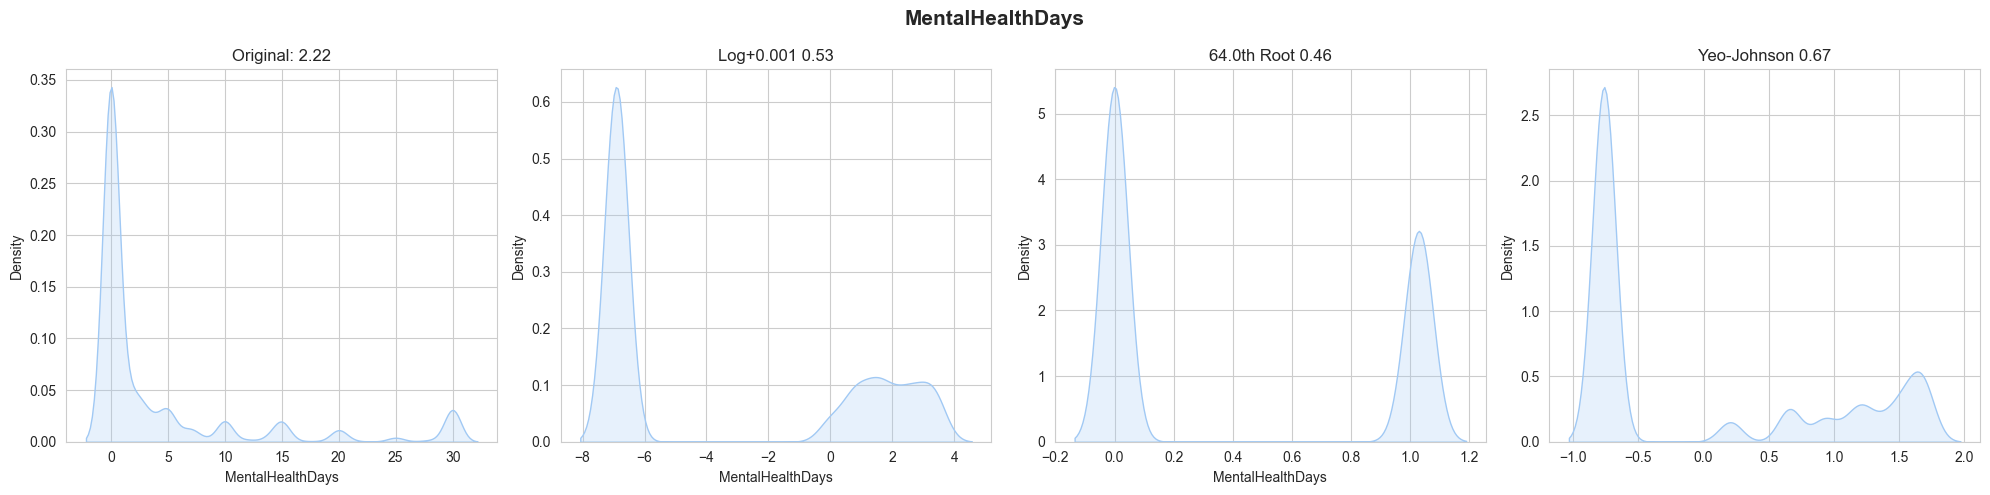

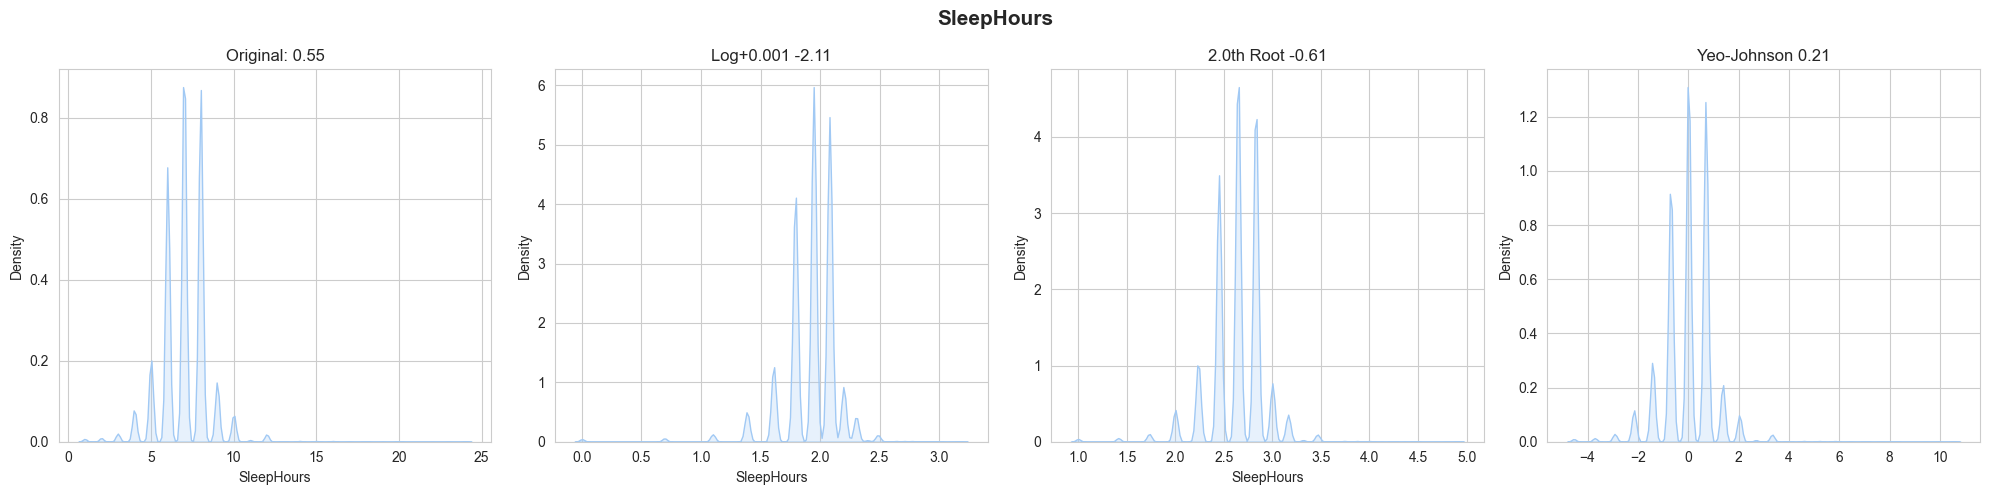

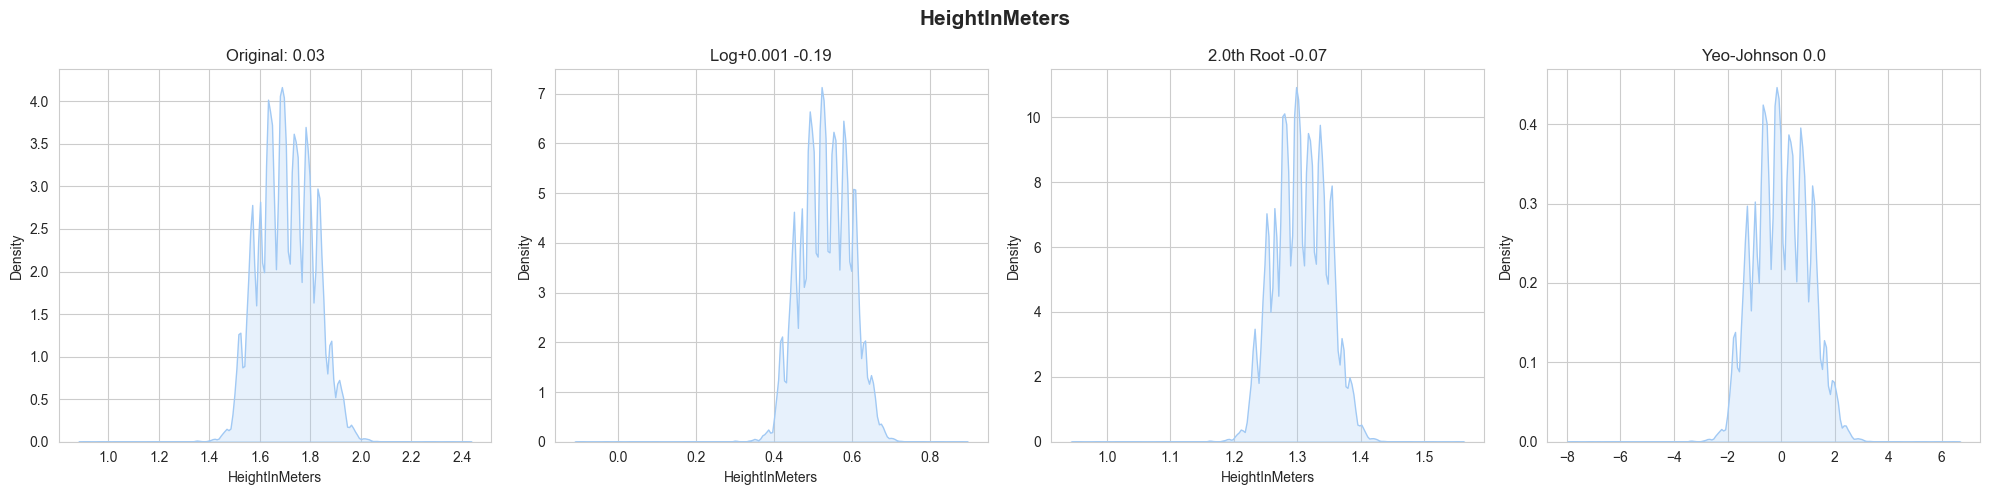

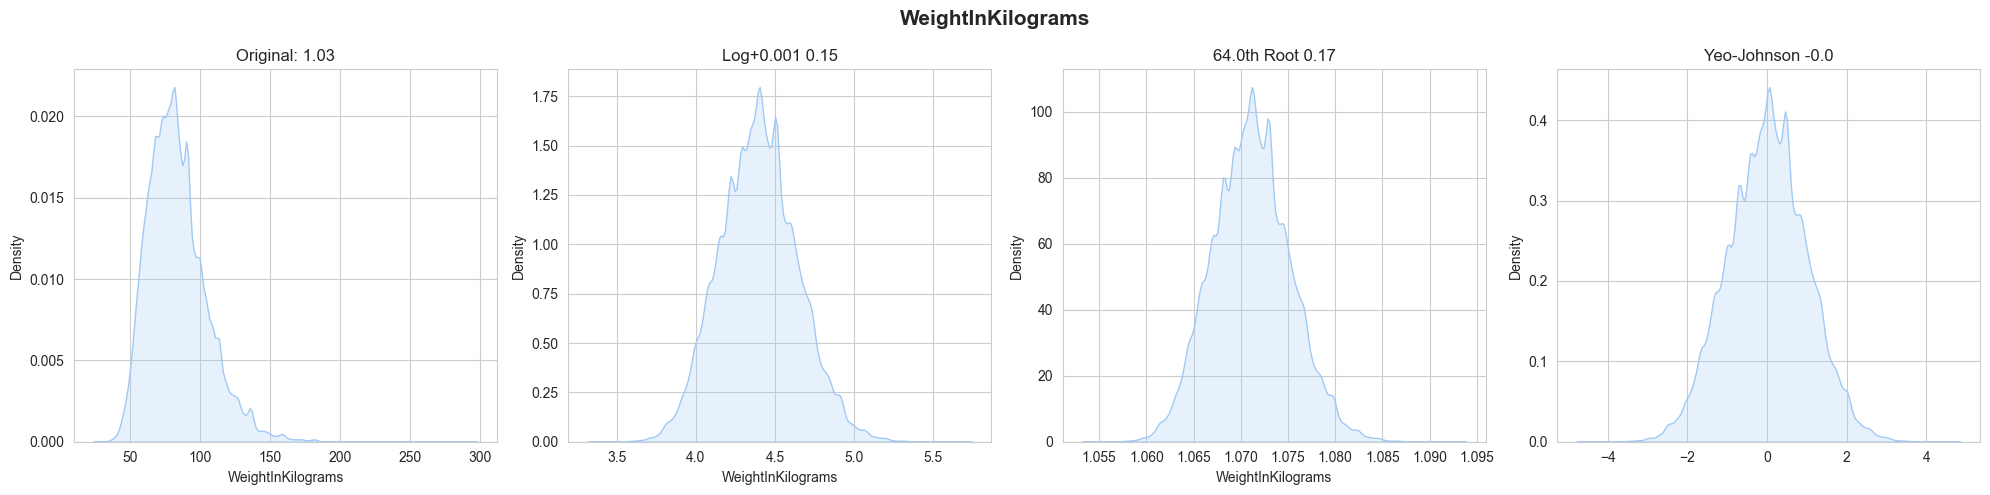

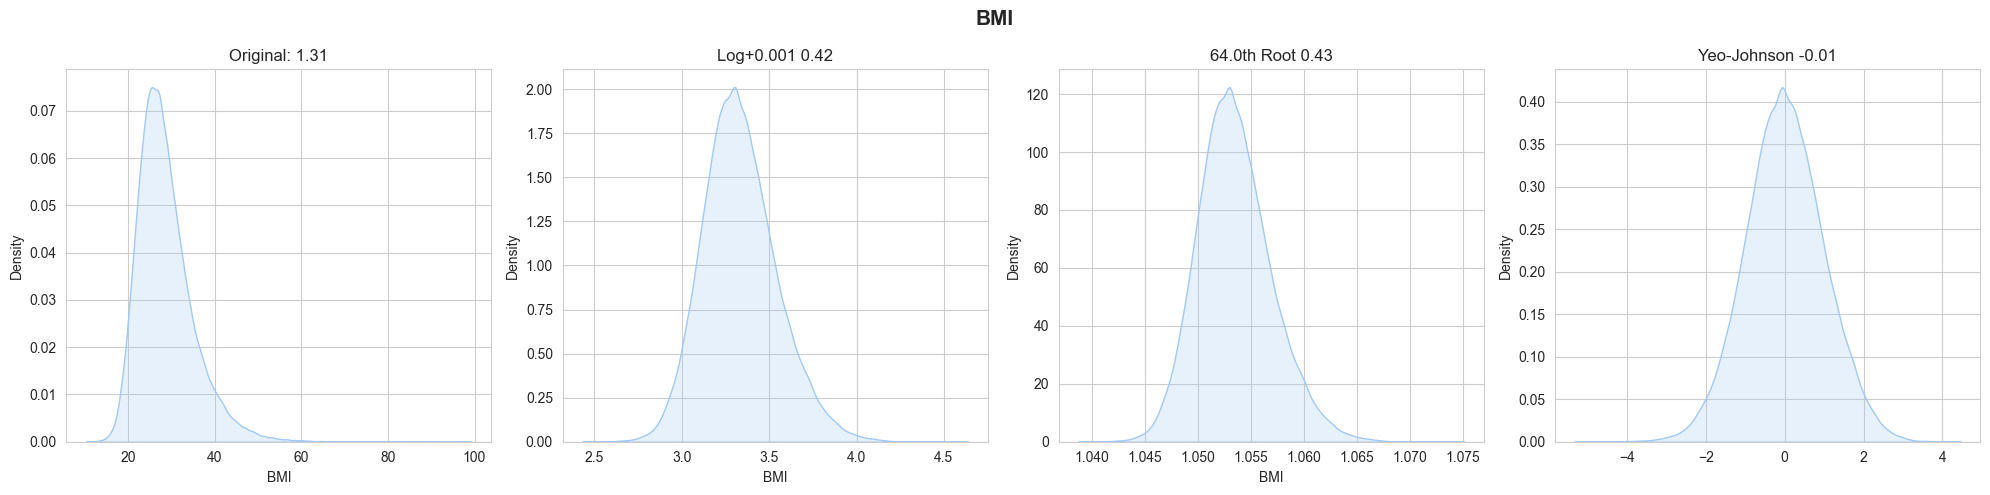

In [33]:
from scipy.stats import skew
for col in numeric_cols:
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    skf = X_train[col].skew().round(2)
    sns.kdeplot(X_train[col], ax=ax[0], fill=True)
    ax[0].set_title(f'Original: {skf}') 
    
    # Log Transformation
    gridsv, best, skf = [0.001, 1, 10, 100, 1000, 10000], 0.001, 200
    for i in gridsv:
        n_skf = skew(np.log(best+X_train[col]))
        if abs(n_skf) < abs(skf):
            skf = n_skf
            best = i
    
    log_transformed = np.log(best+X_train[col])
    skf = round(skew(log_transformed), 2)
    sns.kdeplot(log_transformed, ax=ax[1], fill=True)
    ax[1].set_title(f'Log+{best} {skf}')
    
    # Nth Root Transformation
    gridsv, best, skf = [1/2, 1/4, 1/8, 1/16, 1/32, 1/64], 1/2, 200
    for i in gridsv:
        n_skf = skew(np.power(X_train[col], i))
        if abs(n_skf) < abs(skf):
            skf = n_skf
            best = i
    
    nth_root_transformed = np.power(X_train[col], best)
    sns.kdeplot(nth_root_transformed, ax=ax[2], fill=True)
    skf = round(skew(nth_root_transformed), 2)
    ax[2].set_title(f'{1/best}th Root {skf}')
    
    # Ye-Johnson Transformation
    transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    yeo_johnson_transformed = transformer.fit_transform(X_train[[col]]+1)[:, 0]
    skf = round(skew(yeo_johnson_transformed), 2)
    sns.kdeplot(yeo_johnson_transformed, ax=ax[3], fill=True)
    ax[3].set_title(f'Yeo-Johnson {skf}')
    
    plt.suptitle(f'{col}', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    

### Multicolinearity
    - consider dropping HeightInMeters and WeightInKilograms since BMI is already in the dataset

In [34]:
numeric_power = ['BMI', 'WeightInKilograms', 'HeightInMeters', 'SleepHours']
num_pipeline1 = Pipeline([
    ('transform', PowerTransformer()),
    ('scale',StandardScaler()) ])
num_pipeline1

Pipeline(steps=[('transform', PowerTransformer()), ('scale', StandardScaler())])

In [35]:
class NRootTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n = 1/2, random_state = 42):
        self.random_state = random_state
        self.n = n
        
    def fit(self, X, y = None):
        self.feature_names = X.columns
        return self
    
    def transform(self, X):
        return np.power(X, self.n)
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def get_feature_names_out(self, names = None):
        return self.feature_names
    
numeric_nth_root = ['PhysicalHealthDays', 'MentalHealthDays']
power_transformer = NRootTransformer(n = 1/64)

In [36]:
num_pipeline2 = Pipeline([
    ('transform', power_transformer),
    ('scale',StandardScaler()) ])
num_pipeline2

Pipeline(steps=[('transform', NRootTransformer(n=0.015625)),
                ('scale', StandardScaler())])

In [37]:
print(f'Ordinal Encode: {categorical_cols}')
print(f'Power Transform: {numeric_power}')
print(f'Nth Root Transform: {numeric_nth_root}')

Ordinal Encode: Index(['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'AgeCategory', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')
Power Transform: ['BMI', 'WeightInKilograms', 'HeightInMeters', 'SleepHours']
Nth Root Transform: ['PhysicalHealthDays', 'MentalHealthDays']


In [38]:
preprocessor = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), categorical_cols),
    ('power', num_pipeline1, numeric_power),
    ('nth_root', num_pipeline2, numeric_nth_root)
    ], remainder='drop'
)
preprocessor

ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                 Index(['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities',
       'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
       'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating'...
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')),
                                ('power',
                                 Pipeline(steps=[('transform',
                                                  PowerTransformer()),
                                                 ('scale', StandardScaler())]),
                                 ['BMI', 'WeightInKilograms', 'HeightInMeters',
                                  'SleepHours']),
                                ('nth_root',
                                 Pipeline(steps=[('transform',
                                                  NRootTransformer(n=0.015625)),
                                                 ('scale', StandardScaler())]),
                                 ['PhysicalHealthDays', 'MentalHealthDays'])])

In [39]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

print(X_train_preprocessed[0])

[ 1.          1.          3.          1.          3.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          2.          0.
  0.          1.37745897  1.96340819  1.62995054  0.68810257 -0.78036326
  1.27725276]


In [40]:
y_train = y_train.replace({'Yes': 1, 'No' : 0})
y_test = y_test.replace({'Yes': 1, 'No' : 0})
y_val = y_val.replace({'Yes': 1, 'No' : 0})

## Logistic Regression Baseline

In [41]:
def plot_confusion_matrix(y_val, y_val_pred):
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_val, y_val_pred, normalize='true'),
                annot=True, fmt=".3f", linewidth=.5, cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

f1_score: 0.37209302325581395
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23258
           1       0.58      0.27      0.37      1344

    accuracy                           0.95     24602
   macro avg       0.77      0.63      0.67     24602
weighted avg       0.94      0.95      0.94     24602



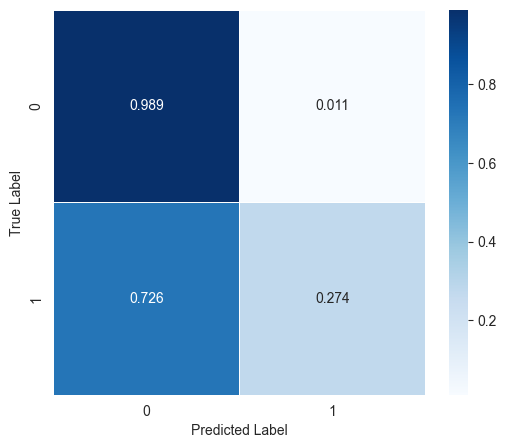

In [42]:
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_preprocessed, y_train)

y_val_pred = lr.predict(X_val_preprocessed)

print(f'f1_score: {f1_score(y_val, y_val_pred)}')
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(y_val, y_val_pred)

## Undersampling vs Oversampling
    - undersampling reduces the number of samples in the majority class
        - pros: can help improve runtime and storage problem in a large dataset
        - cons: can discard potentially useful data
        
    - oversampling add more samples of the minority class 
        - implemented by duplicating or genrating new samples using SMOTE
        - pros: no infomation loss, outperforms undersampling with small data sets
        - cons: increase likelihood of overfitting since it replicates minority events, slow with large dataset

### Generated Undersampling
    - Cluster Centroids
### Controlled Undersampling
    - Random Undersampling
    - Near Miss
### Cleaned Undersampling
    - Tomek's Links
    - Edited Nearest Neighboors
    - Repeated Edited Nearest Neighboors
    - ALL KNN
    - One Sided Selection
    - Neighbourhood Cleaning Rule
    - Instance Hardness Threshold

In [53]:
def test_undersamplers(under_sampler_list, X_train_preprocessed, y_train, X_val_preprocessed, y_val):
    for sampler in under_sampler_list:
        print(f'Under Sampler: {sampler}')
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)
        lr = LogisticRegression(random_state=42, max_iter=1000)
        lr.fit(X_train_resampled, y_train_resampled)
        y_val_pred = lr.predict(X_val_preprocessed)
        print(f'f1_score: {f1_score(y_val, y_val_pred)}')
        print(classification_report(y_val, y_val_pred))
        plot_confusion_matrix(y_val, y_val_pred)
        print('-'*100)

Under Sampler: ClusterCentroids()
f1_score: 0.3321878579610538
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     23258
           1       0.21      0.76      0.33      1344

    accuracy                           0.83     24602
   macro avg       0.60      0.80      0.62     24602
weighted avg       0.94      0.83      0.87     24602



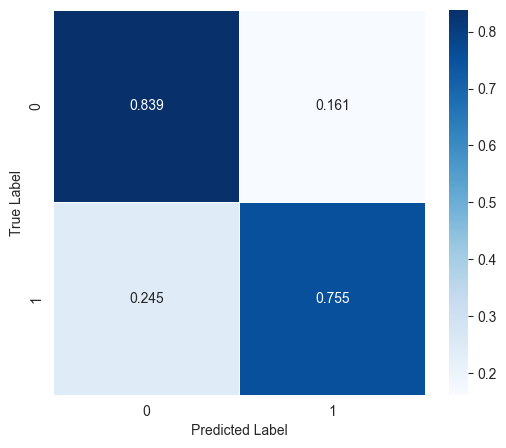

----------------------------------------------------------------------------------------------------
Under Sampler: RandomUnderSampler()
f1_score: 0.3389223506430083
              precision    recall  f1-score   support

           0       0.98      0.84      0.91     23258
           1       0.22      0.77      0.34      1344

    accuracy                           0.83     24602
   macro avg       0.60      0.81      0.62     24602
weighted avg       0.94      0.83      0.87     24602



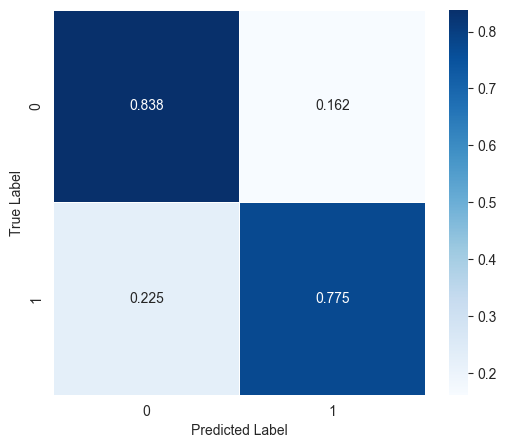

----------------------------------------------------------------------------------------------------
Under Sampler: NearMiss()
f1_score: 0.13029844290657439
              precision    recall  f1-score   support

           0       0.98      0.31      0.48     23258
           1       0.07      0.90      0.13      1344

    accuracy                           0.35     24602
   macro avg       0.53      0.61      0.30     24602
weighted avg       0.93      0.35      0.46     24602



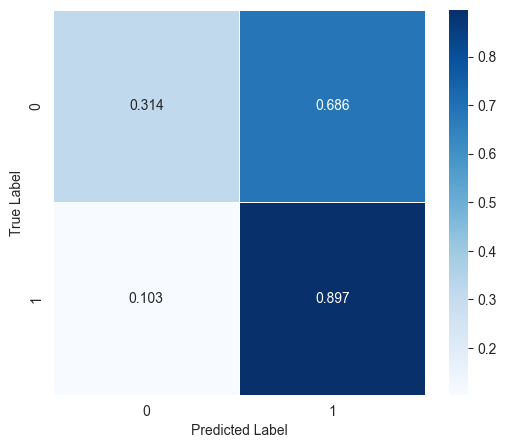

----------------------------------------------------------------------------------------------------
Under Sampler: TomekLinks()
f1_score: 0.38472834067547723
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23258
           1       0.56      0.29      0.38      1344

    accuracy                           0.95     24602
   macro avg       0.76      0.64      0.68     24602
weighted avg       0.94      0.95      0.94     24602



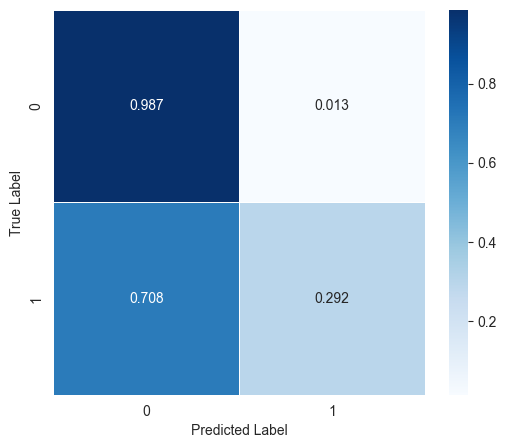

----------------------------------------------------------------------------------------------------
Under Sampler: EditedNearestNeighbours()
f1_score: 0.4500205676676265
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23258
           1       0.50      0.41      0.45      1344

    accuracy                           0.95     24602
   macro avg       0.73      0.69      0.71     24602
weighted avg       0.94      0.95      0.94     24602



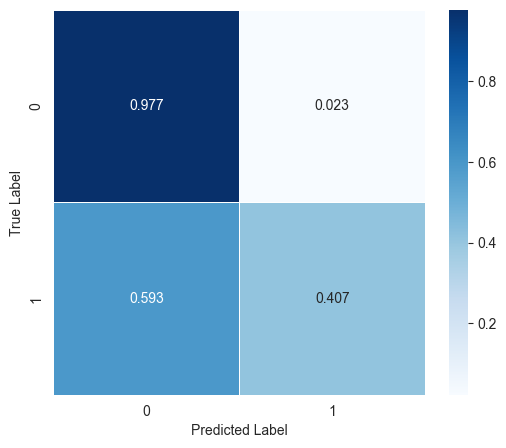

----------------------------------------------------------------------------------------------------
Under Sampler: RepeatedEditedNearestNeighbours()
f1_score: 0.4597432905484247
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     23258
           1       0.48      0.44      0.46      1344

    accuracy                           0.94     24602
   macro avg       0.72      0.71      0.71     24602
weighted avg       0.94      0.94      0.94     24602



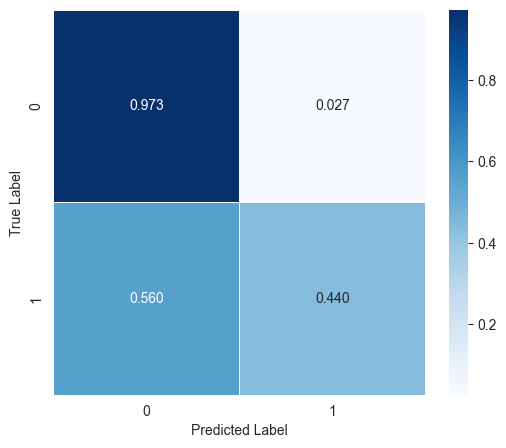

----------------------------------------------------------------------------------------------------
Under Sampler: AllKNN()
f1_score: 0.4569827931172469
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     23258
           1       0.49      0.42      0.46      1344

    accuracy                           0.94     24602
   macro avg       0.73      0.70      0.71     24602
weighted avg       0.94      0.94      0.94     24602



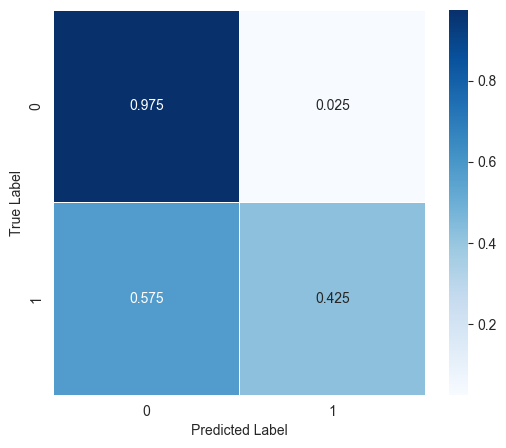

----------------------------------------------------------------------------------------------------
Under Sampler: OneSidedSelection()
f1_score: 0.3863080684596577
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23258
           1       0.56      0.29      0.39      1344

    accuracy                           0.95     24602
   macro avg       0.76      0.64      0.68     24602
weighted avg       0.94      0.95      0.94     24602



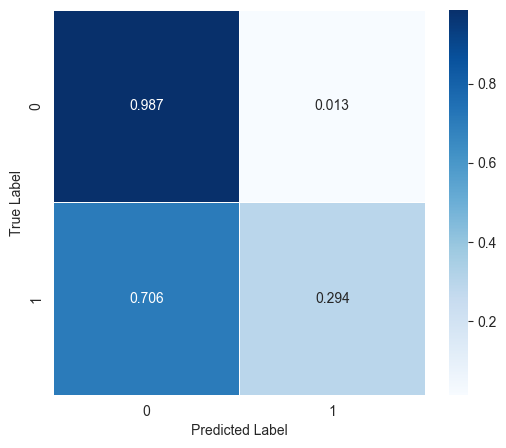

----------------------------------------------------------------------------------------------------
Under Sampler: NeighbourhoodCleaningRule()
f1_score: 0.4425459205467749
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23258
           1       0.52      0.39      0.44      1344

    accuracy                           0.95     24602
   macro avg       0.74      0.68      0.71     24602
weighted avg       0.94      0.95      0.94     24602



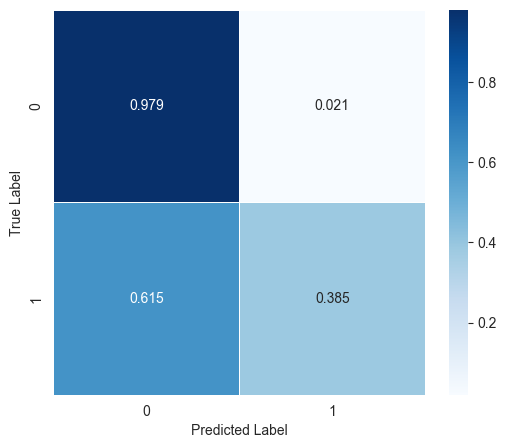

----------------------------------------------------------------------------------------------------
Under Sampler: InstanceHardnessThreshold()
f1_score: 0.2684240687679083
              precision    recall  f1-score   support

           0       0.99      0.73      0.84     23258
           1       0.16      0.87      0.27      1344

    accuracy                           0.74     24602
   macro avg       0.57      0.80      0.56     24602
weighted avg       0.94      0.74      0.81     24602



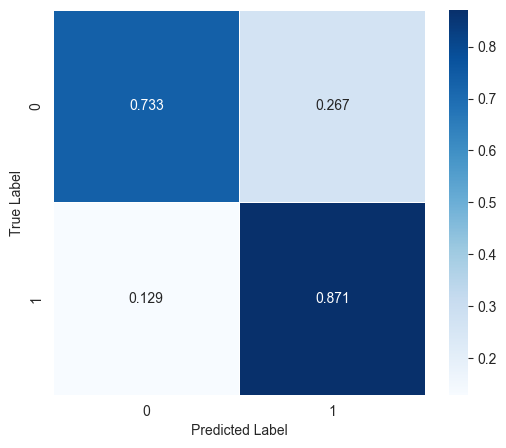

----------------------------------------------------------------------------------------------------


In [55]:
under_sampler_list = [
    ClusterCentroids(), 
    RandomUnderSampler(), NearMiss(), 
    TomekLinks(), EditedNearestNeighbours(), RepeatedEditedNearestNeighbours(), 
    AllKNN(), OneSidedSelection(), NeighbourhoodCleaningRule(), InstanceHardnessThreshold()
]

test_undersamplers(under_sampler_list, X_train_preprocessed, y_train, X_val_preprocessed, y_val)

## Choosing a Model

In [56]:
renn = RepeatedEditedNearestNeighbours()
X_train_resampled, y_train_resampled = renn.fit_resample(X_train_preprocessed, y_train)

In [58]:
classifiers = {
    # Nearest Neighbors
    'KNN': KNeighborsClassifier(),
    # Linear Models
    'LogisticRegression':LogisticRegression(random_state=42, max_iter=10000),
    'SGDClassifier':SGDClassifier(random_state=42),
    # Support Vector Machine
    'LinearSVC':LinearSVC(random_state=42, max_iter=10000),
    # Tree Based Models
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=42),
    # Ensemble Models
    'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'CatBoostClassifier':CatBoostClassifier(random_state=42, verbose=False),
    'XGBClassifier': XGBClassifier(random_state=42),
    'LGBMClassifier':LGBMClassifier(random_state=42, verbose=0),
    # AdaBoost
    'AdaBoostClassifier': AdaBoostClassifier(algorithm="SAMME", random_state=42),
    # Neural Networks
    'MLPClassifier': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
}

In [59]:
train_scores = dict()
val_scores = dict()

for name, classifier in classifiers.items():
    print(f'Training {name}...')
    classifier.fit(X_train_resampled, y_train_resampled)
    y_train_pred = classifier.predict(X_train_resampled)
    y_val_pred = classifier.predict(X_val_preprocessed)
    train_score = {
        'recall' : recall_score(y_train_resampled, y_train_pred, zero_division=0),
        'precision' : precision_score(y_train_resampled, y_train_pred, zero_division=0),
        'accuracy' : accuracy_score(y_train_resampled, y_train_pred),
        'f1_score' : f1_score(y_train_resampled, y_train_pred, zero_division=0),
        'auc_score': roc_auc_score(y_train_resampled, y_train_pred),
    }
    val_score = { 
        'recall' : recall_score(y_val, y_val_pred, zero_division=0),
        'precision' : precision_score(y_val, y_val_pred, zero_division=0),
        'accuracy' : accuracy_score(y_val, y_val_pred),
        'f1_score' : f1_score(y_val, y_val_pred, zero_division=0),
        'auc_score': roc_auc_score(y_val, y_val_pred),
    }
    train_scores[name] = train_score
    val_scores[name] = val_score
    print(f'Training {name} Completed\n')
    print(f'F1 Train Score: {train_score["f1_score"]}')
    print(f'F1 Validation Score: {val_score["f1_score"]}')
    print('-'*100)

Training KNN...
Training KNN Completed

F1 Train Score: 0.4495919544967439
F1 Validation Score: 0.24559637644690488
----------------------------------------------------------------------------------------------------
Training LogisticRegression...
Training LogisticRegression Completed

F1 Train Score: 0.5362746412766528
F1 Validation Score: 0.4597432905484247
----------------------------------------------------------------------------------------------------
Training SGDClassifier...
Training SGDClassifier Completed

F1 Train Score: 0.5524959134917641
F1 Validation Score: 0.4725519287833828
----------------------------------------------------------------------------------------------------
Training LinearSVC...
Training LinearSVC Completed

F1 Train Score: 0.5581482405789868
F1 Validation Score: 0.4762605815237394
----------------------------------------------------------------------------------------------------
Training DecisionTreeClassifier...
Training DecisionTreeClassifier Comple

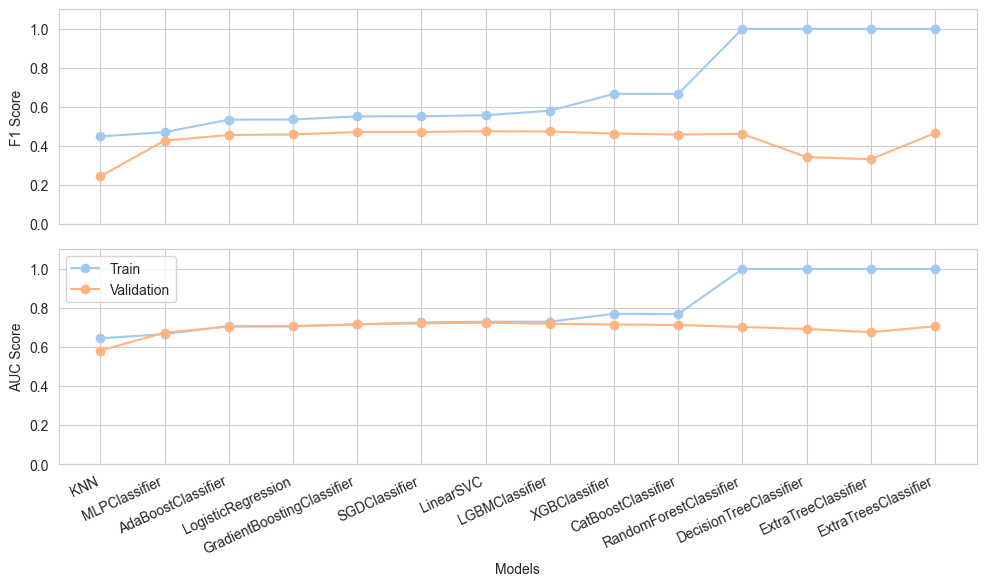

In [60]:
train_models_scores = pd.DataFrame(train_scores).T.sort_values(by = ['f1_score', 'auc_score',])
val_models_scores = pd.DataFrame(val_scores).T.loc[list(train_models_scores.index.values)]

fig, ax = plt.subplots(2, 1,sharex=True ,figsize=(10, 6))

ax[0].plot(train_models_scores['f1_score'], marker = 'o', linewidth = 1.5, label = 'Train')
ax[0].plot(val_models_scores['f1_score'], marker = 'o', linewidth = 1.5, label = 'Validation')
ax[0].set_ylabel('F1 Score')
ax[0].set_ylim([0, 1.1])

ax[1].plot(train_models_scores['auc_score'], marker = 'o', linewidth = 1.5, label = 'Train')
ax[1].plot(val_models_scores['auc_score'], marker = 'o', linewidth = 1.5, label = 'Validation')
ax[1].set_ylabel('AUC Score')
ax[1].set_ylim([0, 1.1])

plt.xlabel('Models')

plt.xticks(size=10,rotation=25, horizontalalignment='right',fontweight='light')
plt.legend()
plt.tight_layout(pad=1.2)
plt.show()

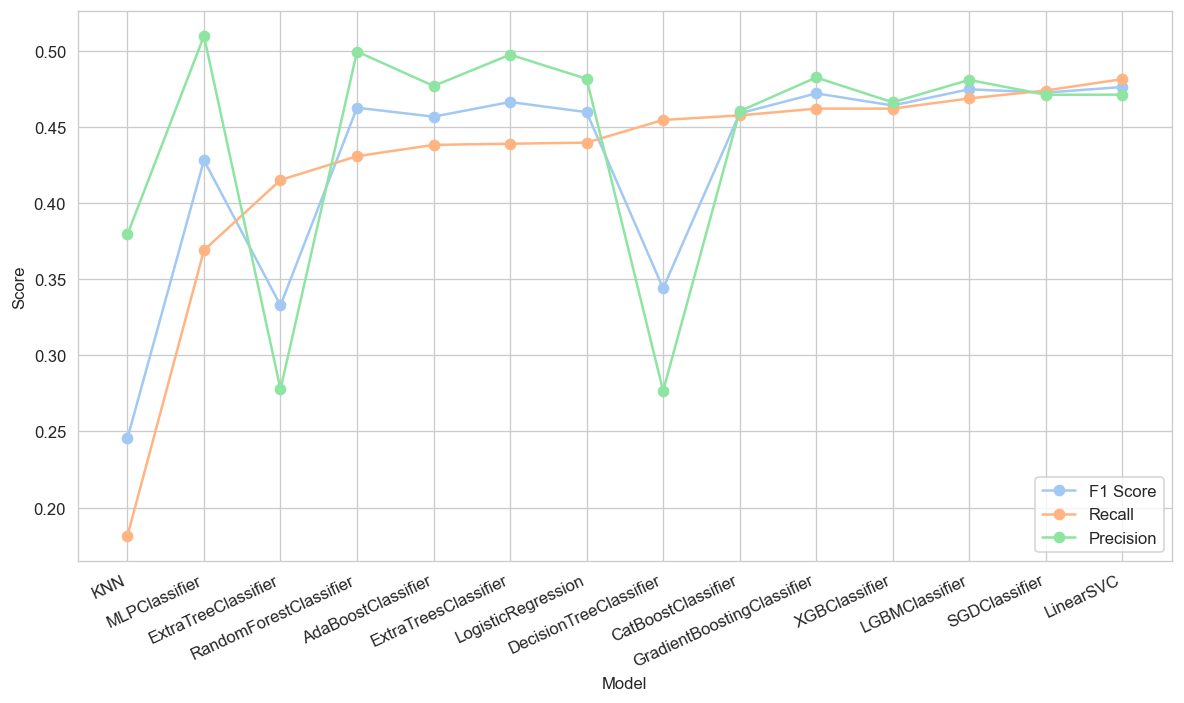

In [61]:
plt.figure(figsize=(10, 6), dpi = 120)
val_models_scores=val_models_scores.sort_values(by='recall')

plt.plot(val_models_scores['f1_score'], marker = 'o', linewidth = 1.5, label = 'F1 Score')
plt.plot(val_models_scores['recall'], marker = 'o', linewidth = 1.5, label = 'Recall')
plt.plot(val_models_scores['precision'], marker = 'o', linewidth = 1.5, label = 'Precision')

plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(size=10, rotation=25, horizontalalignment='right', fontweight='light')
plt.legend()
plt.tight_layout(pad=1.2)
plt.show()

## Hyperparameter Tuning

In [48]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

renn = RepeatedEditedNearestNeighbours()
X_train_resampled, y_train_resampled = renn.fit_resample(X_train_preprocessed, y_train)

param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

lgb_model = lgb.LGBMClassifier(verbose=0)

grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 20, 'subsample': 0.8}
Best Score: 0.5528278689654226


[LightGBM] [Info] Number of positive: 9404, number of negative: 144157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 153561, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061240 -> initscore=-2.729768
[LightGBM] [Info] Start training from score -2.729768
f1_score: 0.47231638418079097
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     23258
           1       0.48      0.47      0.47      1344

    accuracy                           0.94     24602
   macro avg       0.72      0.72      0.72     24602
weighted avg       0.94      0.94      0.94     24602



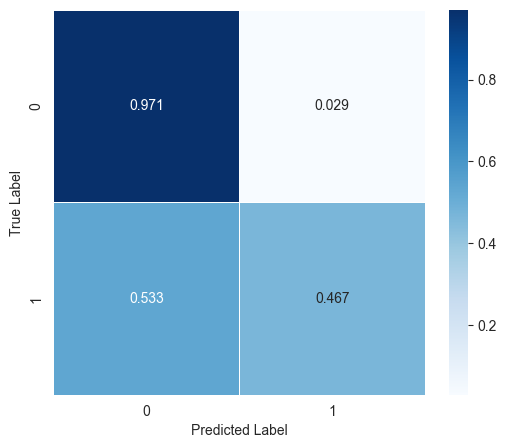

In [49]:
lgbm = LGBMClassifier(**best_params)
lgbm.fit(X_train_resampled, y_train_resampled)

y_val_pred = lgbm.predict(X_val_preprocessed)
print(f'f1_score: {f1_score(y_val, y_val_pred)}')
print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(y_val, y_val_pred)    